# MLP with Keras

## Loading the packages

## The Dataset
The following script allows you to create a 2D dataset by using the mouse. The left click adds points belonging to class A (blue), and the right click adds points belonging to class B (red). You can create as many points as you desire. The final dataset will contain hence three values per point: x coordinate (-1 ≤ x ≤ 1), y coordinate (-1 ≤ y ≤ 1) and the class ∈ {1,-1}.

In [1]:
%pip install ipympl

Note: you may need to restart the kernel to use updated packages.


<font color="red">**For it to work on Colab, you will need to reload your session (Exécution -> redémarrer la session)**</font>

<font color="orange">**Make sure to put a large amount of points otherwise the cross validation folds will be really small**</font>

In [2]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as pl

# Will store manually clicked points and generated points
dataset = []

def generate_points(n, mode="blobs", seed=1):
    """
    Generate n points in the range [-1.2, 1.2] according to a chosen mode.

    Modes:
        "blobs"      -> two well-separated clusters
        "circles"    -> mixed classes using circular structure
        "unbalanced" -> unbalanced dataset (90/10)
        "random"     -> fully random distribution

    Returns:
        A list of (x, y, class) tuples, where class is -1 or +1,
        fully compatible with your existing visualization logic.
    """
    np.random.seed(seed)

    if mode == "blobs":
        centers = [(-0.7, -0.7), (0.7, 0.7)]
        X = []
        y = []
        for i, c in enumerate(centers):
            X.append(np.random.normal(loc=c, scale=0.15, size=(n//2, 2)))
            y.append(np.full(n//2, i))
        X = np.vstack(X)
        y = np.hstack(y)

    elif mode == "circles":
        r = np.random.rand(n)
        theta = np.random.rand(n) * 2 * np.pi
        X = np.column_stack((r * np.cos(theta), r * np.sin(theta)))
        y = (r > 0.5).astype(int)

    elif mode == "unbalanced":
        majority = int(n * 0.9)
        minority = n - majority
        X_major = np.random.normal(loc=(-0.7, -0.7), scale=0.25, size=(majority, 2))
        X_minor = np.random.normal(loc=(0.7, 0.7), scale=0.25, size=(minority, 2))
        X = np.vstack([X_major, X_minor])
        y = np.hstack([np.zeros(majority), np.ones(minority)])

    elif mode == "random":
        X = np.random.uniform(-1.0, 1.0, size=(n, 2))
        y = np.random.randint(0, 2, size=n)

    else:
        raise ValueError("Unknown mode")

    # Convert class {0,1} → {-1,+1} to match your click logic
    return [(X[i,0], X[i,1], y[i]*2 - 1) for i in range(len(y))]


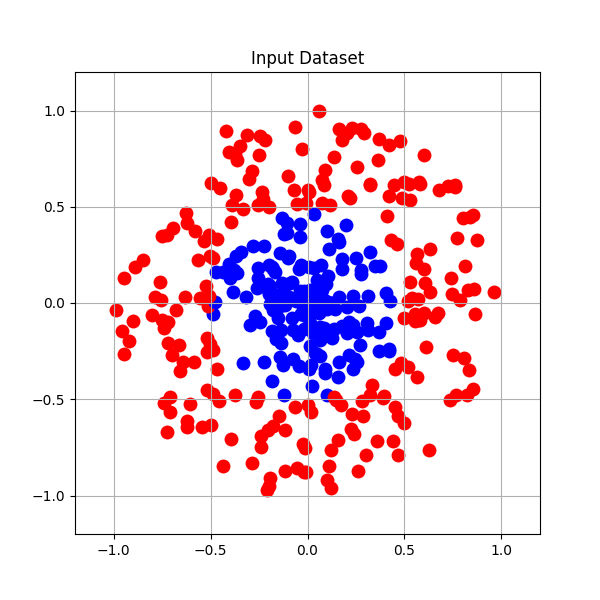

In [3]:
# Example: auto-generate points (change mode as needed)
# Options: "blobs", "circles", "unbalanced", "random"
generated = generate_points(400, mode="circles", seed=1)
dataset.extend(generated)

# Interactive figure
fig = pl.figure(figsize=(6,6))
pl.title("Input Dataset")
pl.xlim((-1.2, 1.2))
pl.ylim((-1.2, 1.2))

# Initial rendering
for x, y, c in dataset:
    pl.scatter(x, y, c=("b" if c == -1 else "r"), s=100, lw=0)

# Click handler
def onclick(event):
    global dataset
    cx = event.xdata
    cy = event.ydata
    co = event.button        # left = 1, right = 3
    cls = co - 2             # left = -1, right = +1

    dataset.append((cx, cy, cls))
    pl.scatter(cx, cy, c=("b" if cls == -1 else "r"), s=100, lw=0)
    pl.grid(True)

cid = fig.canvas.mpl_connect('button_press_event', onclick)
pl.grid(True)


In [4]:
fig.canvas.mpl_disconnect(cid)

## Show the dataset

In [5]:
dataset = np.array(dataset)
dataset

array([[ 4.03549331e-01, -1.05144138e-01, -1.00000000e+00],
       [ 2.39571151e-01, -6.79318069e-01,  1.00000000e+00],
       [ 1.12024146e-04,  2.30692363e-05, -1.00000000e+00],
       ...,
       [-7.21228134e-01, -2.05225400e-01,  1.00000000e+00],
       [-5.09670220e-01,  3.87540703e-02,  1.00000000e+00],
       [ 3.32509547e-01, -4.26692227e-01,  1.00000000e+00]])

In [6]:
input_data = dataset[:,0:2]
output_data = dataset[:,2]

In [7]:
input_data

array([[ 4.03549331e-01, -1.05144138e-01],
       [ 2.39571151e-01, -6.79318069e-01],
       [ 1.12024146e-04,  2.30692363e-05],
       [-7.63139093e-02, -2.92542598e-01],
       [-1.43221832e-01,  3.20124725e-02],
       [ 8.73693860e-02, -2.98832139e-02],
       [ 3.32532514e-02,  1.83267803e-01],
       [-3.69961037e-02,  3.43574598e-01],
       [ 3.45904879e-01,  1.94355970e-01],
       [-4.85526708e-01,  2.33639228e-01],
       [ 3.24636169e-01,  2.65208218e-01],
       [-4.57048737e-01, -5.10521513e-01],
       [ 6.67883600e-02, -1.93235704e-01],
       [-2.88086119e-01, -8.29515895e-01],
       [ 2.78485446e-03, -2.72456390e-02],
       [-3.67940403e-01,  5.60487771e-01],
       [ 2.36403260e-01, -3.43884860e-01],
       [-5.03662330e-01,  2.41782095e-01],
       [ 6.29549291e-02, -1.25479757e-01],
       [-1.38755905e-01, -1.41389529e-01],
       [ 4.97026890e-01,  6.27818552e-01],
       [ 8.53178223e-01,  4.57839927e-01],
       [ 3.11347199e-01,  3.60227313e-02],
       [ 6.

In [8]:
output_data

array([-1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.,
        1., -1.,  1., -1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
       -1., -1., -1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,
        1.,  1.,  1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1.,  1.,
       -1., -1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,
        1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,
        1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1., -1.,
        1., -1.,  1., -1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,
        1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,
        1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1., -1.,
        1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1., -1.,
       -1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,
       -1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,
        1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,  1

In [9]:
%matplotlib inline

<Figure size 600x600 with 0 Axes>

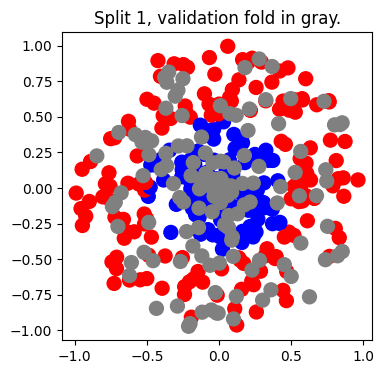

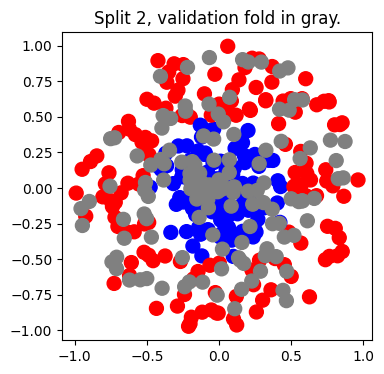

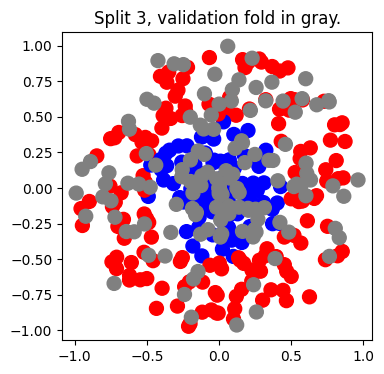

In [10]:
import keras
from keras import layers
from sklearn.model_selection import KFold

pl.clf()

keras.utils.set_random_seed(123)
kf = KFold(n_splits=3, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(input_data)):
  pl.figure(figsize=(4,4))

  # Plot train data
  pl.scatter(input_data[train_index][:,0], input_data[train_index][:,1], c=[(['b', 'r'])[int(d>0)] for d in output_data[train_index]], s=100)
  pl.scatter(input_data[test_index][:,0], input_data[test_index][:,1], c=[(['gray', 'gray'])[int(d>0)] for d in output_data[test_index]], s=100)
  pl.title(f'Split {i + 1}, validation fold in gray.')
  pl.show()

In [ ]:
def create_model():
  # 2 inputs
  # 2 hidden nodes
  # 1 output

  mlp = keras.Sequential([
      layers.Input(shape=(2,)),
      layers.Dense(16, activation="tanh"), # Try different numbers of hidden neurons here (e.g. 2, 4, 8, 32, 128)
      layers.Dense(1, activation="tanh"),
  ])

  # Experiment with hyperparameters here:
  # momentum: [0, 0.8, 0.9, 0.99]
  # learning_rate: [0.1, 0.01, 0.001, 0.0001]
  mlp.compile(
      optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.8),
      loss="mse",
  )

  return mlp

mlp = create_model()
mlp.summary()

I0000 00:00:1763909066.105318  146210 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763909066.243643  146210 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763909066.243753  146210 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763909066.245625  146210 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763909066.245687  146210 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65 (260.00 B)

 Trainable params: 65 (260.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
history_list = []
trained_mlp = []

for i, (train_index, test_index) in enumerate(kf.split(input_data)):
  # We need to create a new model everytime otherwise fit will continue previous training
  mlp = create_model()

  history = mlp.fit(
      x=input_data[train_index], y=output_data[train_index],
      validation_data=(input_data[test_index], output_data[test_index]),
      epochs=100
  )

  history_list.append(history)
  trained_mlp.append(mlp)

Epoch 1/100


I0000 00:00:1763909068.098721  146269 service.cc:146] XLA service 0x796184006880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763909068.098781  146269 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 5060 Ti, Compute Capability 12.0


1/9 ━━━━━━━━━━━━━━━━━━━━ 7s 985ms/step - loss: 0.9744

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
I0000 00:00:1763909068.546334  146269 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.9986 - val_loss: 1.0076
Epoch 2/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9822

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9796 - val_loss: 1.0042
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9923 - val_loss: 1.0260
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0255 - val_loss: 1.0166
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0129 - val_loss: 0.9852
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9770 - val_loss: 0.9773
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9642 - val_loss: 0.9778
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9529 - val_loss: 0.9642
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9341 - val_loss: 0.9515
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9247 - val_loss: 0.9456
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9181 - val_loss: 0.9118
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8692 - val_loss: 0.8413
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7843 - val_loss: 0.7750
Epoch 14/100

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 1.0210 - val_loss: 0.9987
Epoch 2/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0299

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0090 - val_loss: 0.9778
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0222 - val_loss: 0.9989
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0184 - val_loss: 1.0095
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0031 - val_loss: 0.9728
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9966 - val_loss: 0.9506
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9859 - val_loss: 0.9538
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9664 - val_loss: 0.9289
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9553 - val_loss: 0.8961
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9321 - val_loss: 0.8667
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8868 - val_loss: 0.8086
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8411 - val_loss: 0.7213
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7548 - val_loss: 0.5990
Epoch 14/100

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.0607 - val_loss: 1.1153
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0242 - val_loss: 1.0679
Epoch 3/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9624

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0058 - val_loss: 1.0142
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9895 - val_loss: 0.9926
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9622 - val_loss: 1.0543
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9709 - val_loss: 1.0733
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9675 - val_loss: 1.0357
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9385 - val_loss: 0.9895
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8973 - val_loss: 0.9020
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8361 - val_loss: 0.8208
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7728 - val_loss: 0.7737
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6889 - val_loss: 0.7019
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5953 - val_loss: 0.6398
Epoch 14/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5069 - val_loss: 0.5332
Epoch 15/10

# Plot training history

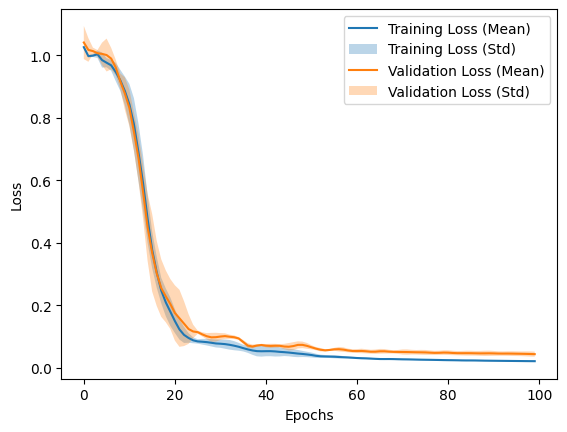

In [13]:
train_losses = np.array([history.history['loss'] for history in history_list])
val_losses = np.array([history.history['val_loss'] for history in history_list])

# Calculate mean and standard deviation for training and validation losses
mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

# Plot mean and standard deviation for training loss
pl.plot(mean_train_loss, label='Training Loss (Mean)')
pl.fill_between(range(len(mean_train_loss)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.3, label='Training Loss (Std)')

# Plot mean and standard deviation for validation loss
pl.plot(mean_val_loss, label='Validation Loss (Mean)')
pl.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3, label='Validation Loss (Std)')

# Add labels and legend
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.legend()

# Display the plot
pl.show()

# Plot models feature space outputs

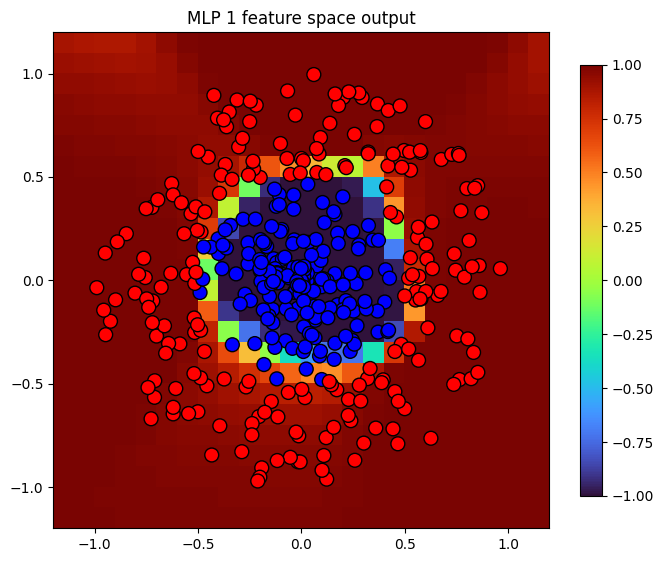

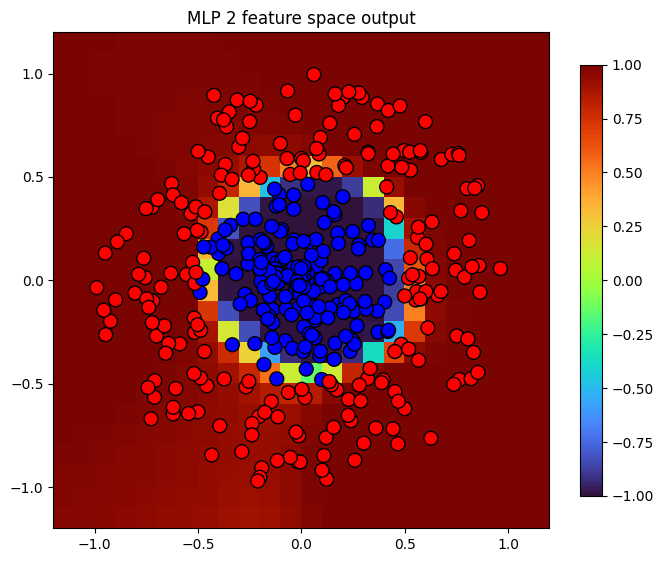

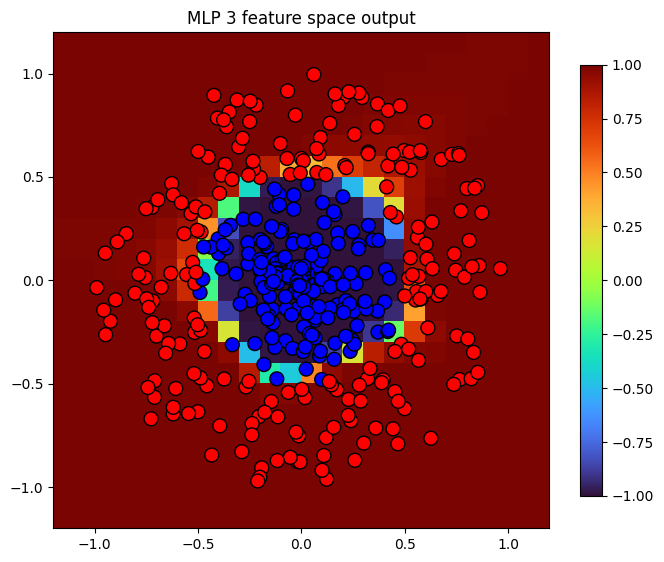

In [14]:
for idx, model in enumerate(trained_mlp):
    # Plot model's output in the feature space
    input_x = np.arange(-1.2, 1.2, 0.1)
    input_y = np.arange(-1.2, 1.2, 0.1)
    input_x_matrix, input_y_matrix = np.meshgrid(input_x, input_y)
    inputs_xy = np.concatenate((input_x_matrix.flatten()[:,np.newaxis], input_y_matrix.flatten()[:,np.newaxis]), axis=1)

    output_values = model(inputs_xy)
    output_matrix = np.reshape(output_values, input_x_matrix.shape)

    pl.figure(figsize=(8,8))
    img = pl.imshow(np.flipud(output_matrix), interpolation='None', extent=(-1.2,1.2,-1.2,1.2), cmap="turbo")
    pl.colorbar(img, shrink=0.7)
    pl.scatter(input_data[:,0], input_data[:,1], c=[(['b', 'r'])[int(d>0)] for d in output_data], s=100, edgecolors='black')
    pl.title(f'MLP {idx+1} feature space output')
    pl.show()

# Performances

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


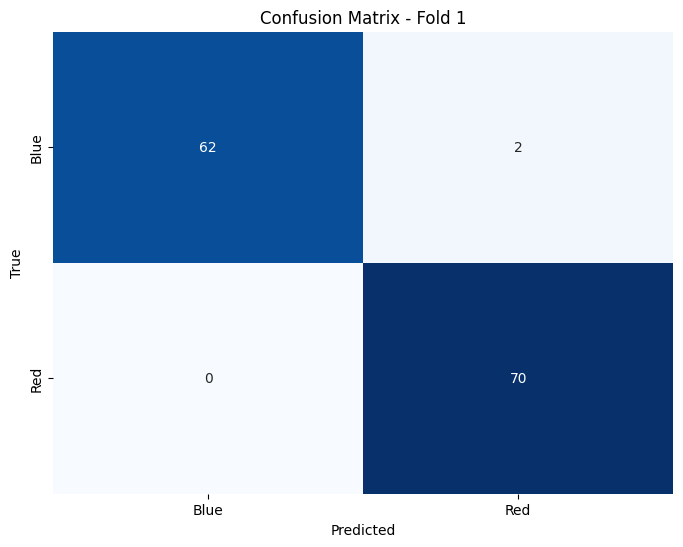

F1 Score - Fold 1: 0.9859154929577465
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


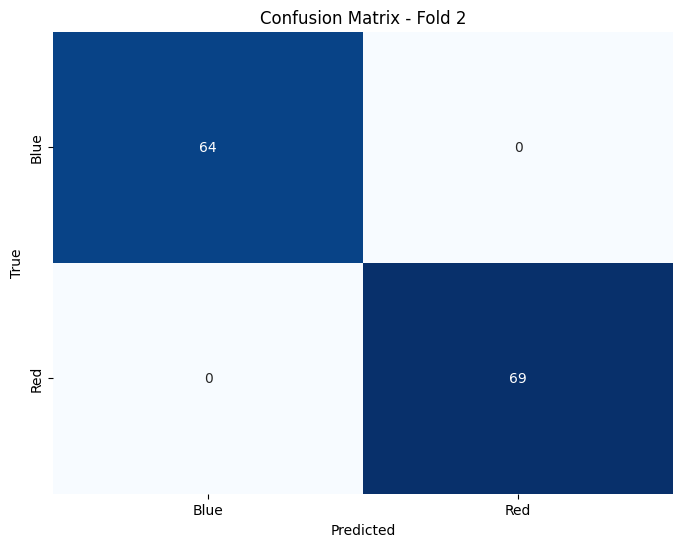

F1 Score - Fold 2: 1.0
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x796491318cc0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


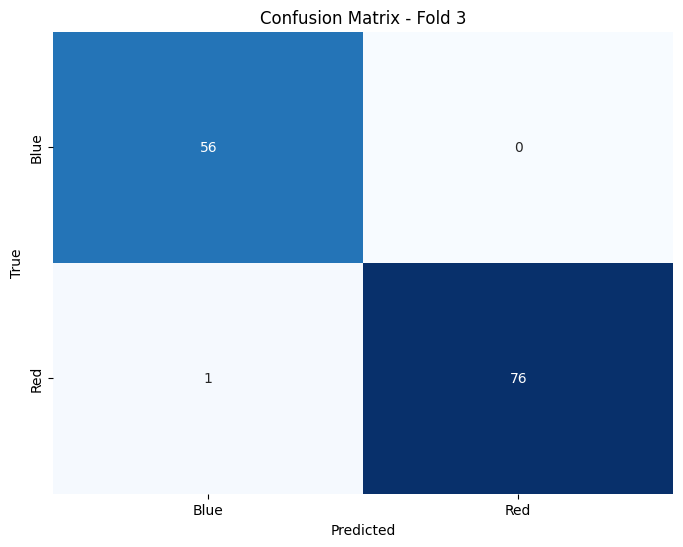

F1 Score - Fold 3: 0.9934640522875817


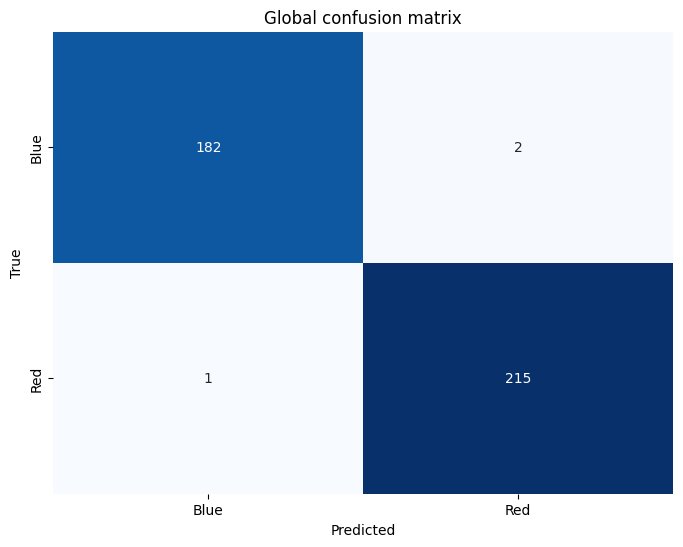

Mean F1 Score across all folds: 0.9931265150817761


In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, title):
    # Plot confusion matrix
    pl.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix.astype(int), annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Blue", "Red"], yticklabels=["Blue", "Red"])
    pl.title(title)
    pl.xlabel('Predicted')
    pl.ylabel('True')
    pl.show()

f1_scores = []
mean_confusion_matrix = np.zeros((2, 2))

for i, (train_index, test_index) in enumerate(kf.split(input_data)):
    # Evaluate the trained model on the test fold
    predictions = (trained_mlp[i].predict(input_data[test_index]) > 0).astype(int)
    true_labels = (output_data[test_index] > 0).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    mean_confusion_matrix += confusion_matrix(true_labels, predictions)

    # Compute confusion matrix and plot
    plot_confusion_matrix(cm, f'Confusion Matrix - Fold {i + 1}')

    # Compute F1 score
    f1 = f1_score(true_labels, predictions)
    f1_scores.append(f1)
    print(f"F1 Score - Fold {i + 1}: {f1}")

# Plot mean confusion matrix
plot_confusion_matrix(mean_confusion_matrix, 'Global confusion matrix')

# Calculate and display the mean F1 score across all folds
mean_f1_score = np.mean(f1_scores)
print(f"Mean F1 Score across all folds: {mean_f1_score}")

# Exercise

Please try changing hyperparameters (number of neurons, number of layers, learning rate, momentum, number of epochs...) and observe the impact it has on training and validation loss, convergence, and computation time. For instance, observe if there's overfitting if you put a high number (i.e. 128) of neurons in the hidden layer.

Experiment with 3 Different Datasets:
Apply the above parameter tuning on three distinct types of datasets:
- Balanced dataset with clear separation between classes.
- Balanced dataset with mixed or overlapping classes.
- Unbalanced dataset (e.g., one class significantly larger than the others).

For each dataset type, select and present the three best experiments (with tuned hyperparameters). Provide relevant results such as confusion matrices and other metrics, and analyze the effects on loss, convergence, computation time, and overfitting.